In [1]:
%pylab inline

import numpy as np
import pylab
import seaborn as sns

import nengo
import nengolib

Populating the interactive namespace from numpy and matplotlib


In [52]:
n_neurons = 1000
theta = 0.01

tau_probe = 0.01
tau_conn = 0.1

process = nengo.processes.WhiteSignal(10., high=5)

def func1(x):
    return np.sin(x)

def func2(x):
    return x**2

with nengolib.Network() as model:
    
    stim = nengo.Node(output=process)
    
    # Ideal
    ideal = nengo.Node(size_in=1)
    nengo.Connection(stim, ideal, function=lambda x: func2(func1(x)), synapse=None)
    p_ideal = nengo.Probe(ideal, synapse=tau_probe)

    # Usual approach
    x1 = nengo.Ensemble(n_neurons, 1)
    x2 = nengo.Ensemble(n_neurons, 1)
    nengo.Connection(stim, x1, function=func1, synapse=tau_conn)
    nengo.Connection(x1, x2, function=func2, synapse=tau_conn)
    p_usual = nengo.Probe(x2, synapse=tau_probe)
    
    # Deconvolution
    r1 = nengolib.networks.RollingWindow(theta, n_neurons, process, input_synapse=None, synapse=tau_conn)
    r2 = nengolib.networks.RollingWindow(theta, n_neurons, process, input_synapse=None, synapse=tau_conn)
    nengo.Connection(stim, r1.input, synapse=tau_conn)
    nengo.Connection(r1.add_output(t=0, function=func1), r2.input, synapse=tau_conn)
    p_deconv = nengo.Probe(r2.add_output(t=0, function=func2), synapse=tau_probe)

In [53]:
assert r1.dt == r2.dt == 0.001
with nengo.Simulator(model) as sim:
    sim.run(1.0)

Building finished in 0:00:05.                                                   
Simulating finished in 0:00:05.                                                 


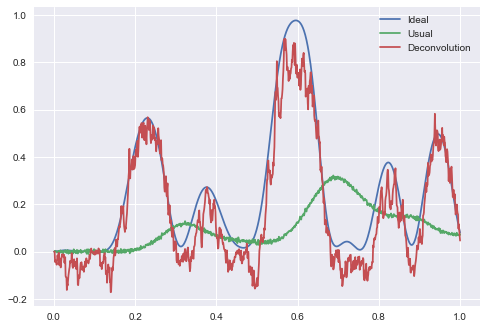

In [54]:
pylab.figure()
pylab.plot(sim.trange(), sim.data[p_ideal], label="Ideal")
pylab.plot(sim.trange(), sim.data[p_usual], label="Usual")
pylab.plot(sim.trange(), sim.data[p_deconv], label="Deconvolution")
pylab.legend()
pylab.show()